In [1]:
import os
import cv2
import pickle	# Used to save variables
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm	# Used to display progress bar
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from keras.models import Model, load_model
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator	# Used to generate images


In [2]:
np.random.seed(22)

In [3]:
# Do not forget to include the last slash
def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array(['normal']*len(norm_files))
    
    norm_images = []
    for image in tqdm(norm_files):
		# Read image
        image = cv2.imread(norm_path + image)
		# Resize image to 200x200 px
        image = cv2.resize(image, dsize=(200,200))
		# Convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels

def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([pneu_file.split('_')[1] for pneu_file in pneu_files])
    
    pneu_images = []
    for image in tqdm(pneu_files):
		# Read image
        image = cv2.imread(pneu_path + image)
		# Resize image to 200x200 px
        image = cv2.resize(image, dsize=(200,200))
		# Convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels



  0%|                                                                                 | 2/1341 [00:00<01:26, 15.47it/s]

Loading images


100%|██████████████████████████████████████████████████████████████████████████████| 3875/3875 [01:38<00:00, 39.50it/s]


(5216, 200, 200)
(5216,)
(array(['bacteria', 'normal', 'virus'], dtype='<U8'), array([2530, 1341, 1345], dtype=int64))
Display several images


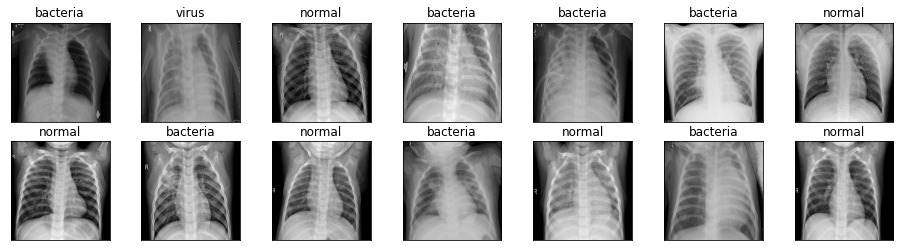

In [4]:
print('Loading images')
# All images are stored in _images, all labels are in _labels
norm_images, norm_labels = load_normal('D://chest_xray/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('D://chest_xray/train/PNEUMONIA/')

# Put all train images to X_train 
X_train = np.append(norm_images, pneu_images, axis=0)

# Put all train labels to y_train
y_train = np.append(norm_labels, pneu_labels)

print(X_train.shape)
print(y_train.shape)
# Finding out the number of samples of each class
print(np.unique(y_train, return_counts=True))

print('Display several images')
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))


indices = np.random.choice(len(X_train), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(y_train[indices[counter]])
        axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()




In [10]:
print('Loading test images')
# Do the exact same thing as what we have done on train data
norm_images_test, norm_labels_test = load_normal('D://chest_xray/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('D://chest_xray/test/PNEUMONIA/')
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
y_test = np.append(norm_labels_test, pneu_labels_test)


  1%|▋                                                                                 | 2/234 [00:00<00:11, 19.47it/s]

Loading test images


100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [00:07<00:00, 53.19it/s]


In [11]:
# Save the loaded images to pickle file for future use
with open('pneumonia_data.pickle', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)

# Here's how to load it
with open('pneumonia_data.pickle', 'rb') as f:
    (X_train, X_test, y_train, y_test) = pickle.load(f)



In [12]:
print('Label preprocessing')

# Create new axis on all y data
y_train = y_train[:, np.newaxis]
y_test = y_test[:, np.newaxis]


Label preprocessing


In [14]:
# Initialize OneHotEncoder object
one_hot_encoder = OneHotEncoder(sparse=False)

# Convert all labels to one-hot
y_train_one_hot = one_hot_encoder.fit_transform(y_train)
y_test_one_hot = one_hot_encoder.transform(y_test)



In [15]:
print('Reshaping X data')
# Reshape the data into (no of samples, height, width, 1), where 1 represents a single color channel
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print('Data augmentation')
# Generate new images with some randomness
datagen = ImageDataGenerator(
		rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train_one_hot, batch_size = 32)


Reshaping X data
Data augmentation


In [ ]:
print('CNN')

# Define the input shape of the neural network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
print(input_shape)

input1 = Input(shape=input_shape)

cnn = Conv2D(16, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Conv2D(16, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = Conv2D(32, (2, 2), activation='relu', strides=(1, 1), 
    padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)

cnn = Flatten()(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(3, activation='softmax')(cnn)

model = Model(inputs=input1, outputs=output1)

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', metrics=['acc'])

# Using fit_generator() instead of fit() because we are going to use data
# taken from the generator. Note that the randomness is changing
# on each epoch
history = model.fit_generator(train_gen, epochs=30, 
          validation_data=(X_test, y_test_one_hot))


CNN
(200, 200, 1)


C:\Users\96777\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
163/163 [==============================] - 336s 2s/step - loss: 7.2969 - acc: 0.5372 - val_loss: 0.7345 - val_acc: 0.7500
Epoch 2/30
163/163 [==============================] - 413s 3s/step - loss: 0.6643 - acc: 0.7071 - val_loss: 0.7495 - val_acc: 0.7724
Epoch 3/30
163/163 [==============================] - 432s 3s/step - loss: 0.6281 - acc: 0.7396 - val_loss: 1.0360 - val_acc: 0.7340
Epoch 4/30
163/163 [==============================] - 430s 3s/step - loss: 0.5816 - acc: 0.7522 - val_loss: 0.8544 - val_acc: 0.7660
Epoch 5/30
163/163 [==============================] - 431s 3s/step - loss: 0.5934 - acc: 0.7525 - val_loss: 0.8779 - val_acc: 0.7548
Epoch 6/30
163/163 [==============================] - 451s 3s/step - loss: 0.5699 - acc: 0.7574 - val_loss: 0.7362 - val_acc: 0.8317
Epoch 7/30
163/163 [==============================] - 435s 3s/step - loss: 0.5724 - acc: 0.7559 - val_loss: 0.8570 - val_acc: 0.8061
Epoch 8/30
163/163 [==============================] - 434s 3s/step - 

In [ ]:
# Saving model
model.save('pneumonia_cnn.h5')

In [ ]:
print('Displaying accuracy')
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()


In [ ]:
print('Displaying loss')
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()


In [ ]:
# Predicting test data
predictions = model.predict(X_test)
print(predictions)


In [ ]:
predictions = one_hot_encoder.inverse_transform(predictions)

print('Model evaluation')
print(one_hot_encoder.categories_)

classnames = ['bacteria', 'normal', 'virus']


In [ ]:
# Display confusion matrix
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
plt.title('Confusion matrix')
sns.heatmap(cm, cbar=False, xticklabels=classnames, yticklabels=classnames, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
